# Crop recommendation and production prediction

Isha Bhagat, UCE2022428

Sakshi Bhatankar, UCE2022433

Ruchi Chandak, UCE2022436


## *Problem Statement:*
   The aim is to develop a predictive model that can forecast crop yields based on various factors such as district, state, season, and crop type.
Additionally, the model will include a crop recommendation component, leveraging supervised machine learning techniques to suggest suitable crops
for cultivation based on soil nutrient levels, environmental factors like temperature, humidity, pH, and rainfall.
By integrating both yield prediction and crop recommendation functionalities, the model will provide farmers with valuable insights into expected crop yields
in advance and offer recommendations on the most suitable crops for their specific agricultural conditions. This comprehensive information enables farmers to
make informed decisions regarding crop selection and planning,ultimately optimizing agricultural productivity and resource allocation.
   
## *Introduction:*
   In agriculture, predicting crop yields is crucial for effective decision-making and resource management. By forecasting yields in advance, farmers can better plan their planting schedules, optimize resource allocation, and mitigate risks associated with crop failure or low yields. Traditional methods of yield prediction often rely on historical data and subjective assessments, which may lack accuracy and reliability.

   Leveraging machine learning techniques offers a more systematic and data-driven approach to crop yield prediction. By analyzing historical yield data along with various contextual factors such as district, state, season, and crop type, predictive models can identify patterns and correlations that contribute to accurate yield forecasts. This project aims to develop such a model to empower farmers with actionable insights for improved crop management and decision-making.

## *Data Set Information:*
   - *Data Source:* [http://localhost:8888/edit/ML%20MiniProject/crop_production.csv],[http://localhost:8888/edit/ML%20MiniProject/Crop_recommendation.csv]
   - *Description of dataset 1, crop production:* The dataset contains historical records of crop yields along with corresponding factors such as district, state, season, and crop type. Each record represents a specific instance of crop cultivation and its corresponding yield.
   - *Sample Data:*
     - District: XYZ
       State: ABC
       Season: Kharif
       Crop Type: Rice
       Yield (in tons/acre): 5.8
     - District: XYZ
       State: DEF
       Season: Rabi
       Crop Type: Wheat
       Yield (in tons/acre): 4.3
       
      *Description of dataset 2, crop recommendation:* The dataset contains records of multiple attributes that determine what type of crop can be grown for the given weather, soil and nutrient availability conditions
   - *Sample Data:*
     - N: 94,
     - P: 50,
     - K: 37,
     - temperature: 25.66585205,
     - humidity: 80.66385045,
     - ph: 6.94801983,
     - rainfall: 209.5869708,
     - label: rice
       
   The dataset will be preprocessed to handle missing values, normalize features, and encode categorical variables as necessary. It will then be divided into training and testing sets for model development and evaluation. Various supervised machine learning techniques such as regression, decision trees, and ensemble methods will be explored to build and optimize the predictive model.



In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Load crop production data
crop_data = pd.read_csv("crop_production.csv")

# Load crop recommendation data
crop_recommendation_data = pd.read_csv("Crop_recommendation.csv")

In [3]:
# Preprocessing for crop production data
# Fill missing values with median for numeric columns
numeric_columns = crop_data.select_dtypes(include=[np.number]).columns
median_values = crop_data[numeric_columns].median()
crop_data.fillna(median_values, inplace=True)

# Add a new column 'Yield' which indicates Production per unit Area
crop_data['Yield'] = crop_data['Production'] / crop_data['Area']

# Preprocessing for crop recommendation data
# Make the label as "Crop" for the crop that can be grown
crop_recommendation_data.rename(columns={'label': 'Crop'}, inplace=True)

# Shuffle the dataset to remove order
crop_recommendation_data = shuffle(crop_recommendation_data, random_state=5)

# View unique crops available in the dataset
unique_crops = crop_recommendation_data['Crop'].unique()

# Create a dictionary to map crop names to integers
crop_to_int = {crop: i + 1 for i, crop in enumerate(unique_crops)}

# Replace crop names with integers in the 'Crop' column
crop_recommendation_data['Crop'] = crop_recommendation_data['Crop'].map(crop_to_int)


In [4]:
# Selection of Feature and Target variables for crop recommendation
X_recommendation = crop_recommendation_data[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y_recommendation = crop_recommendation_data['Crop']

# Reshape y_recommendation to have two dimensions
y_recommendation = y_recommendation.values.reshape(-1, 1)

# Splitting data set for crop recommendation - 25% test dataset and 75% training dataset
X_train_recommendation, X_test_recommendation, y_train_recommendation, y_test_recommendation = \
    train_test_split(X_recommendation, y_recommendation, test_size=0.25)

# Encode the target variable
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train_recommendation).toarray()


## Recommending Crops

### Gaussian Naive Bayes (GNB)

The Gaussian Naive Bayes model is chosen and trained for crop recommendation because it
is a simple yet effective probabilistic classifier, particularly suitable for datasets with
continuous features like the nutrient levels and environmental factors in this agricultural context.
 It assumes that features are independent given the class, especially with limited training data.
    
    
This part initializes a Gaussian Naive Bayes classifier.
Naive Bayes is a probabilistic machine learning algorithm based on Bayes' 
theorem, which assumes that features are independent given the class.
MultiOutputClassifier: Since the task involves multi-label classification (predicting multiple crop labels), MultiOutputClassifier
is used to extend classifiers that do not natively support multi-output to handle such tasks.

In [5]:
# Gaussian Naive Bayes
gnb = GaussianNB()
model_gnb = MultiOutputClassifier(gnb, n_jobs=-1)
model_gnb.fit(X_train_recommendation, y_train_encoded)
gnb_pred = model_gnb.predict(X_test_recommendation)
# Decode one-hot encoded predictions
decoded_predictions = encoder.inverse_transform(gnb_pred)

# Calculate accuracy
acc_gnb = accuracy_score(y_test_recommendation, decoded_predictions)

### Decision tree classifier
The Decision Tree Classifier is chosen and trained for crop recommendation because
it's capable of handling non-linear relationships between features and labels.
It can capture complex interactions among the features and has the ability to handle
both numerical and categorical data, which makes it suitable for this multi-label classification task in agricultural recommendation systems.

 A decision tree is a non-parametric supervised learning method used for classification and regression.
It splits the data into subsets based on the most significant attribute, iteratively creating a tree-like structure until a stopping criterion is met.
MultiOutputClassifier: This is a wrapper used to extend classifiers that do not natively support multi-output to handle multi-label classification tasks.
Here, it's used to predict multiple crop labels simultaneously.

In [6]:
# Initialize and fit the MultiOutputClassifier with DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=6)
multi_target_decision = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_decision.fit(X_train_recommendation, y_train_recommendation)

# Make predictions
decision_pred = multi_target_decision.predict(X_test_recommendation)

# Calculate accuracy
acc_dt = accuracy_score(y_test_recommendation, decision_pred)

### Random Forest Classifier
The Random Forest model with hyperparameter tuning is chosen for crop recommendation because
 it combines the power of multiple decision trees while addressing overfitting and improving generalization performance through hyperparameter optimization.
This ensures that the model can capture complex relationships in the data and make accurate predictions for crop recommendations.

Random Forest is an ensemble learning method that constructs a multitude of decision trees
during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees.
It's known for its high accuracy, robustness, and ability to handle high-dimensional data with noisy features.
Hyperparameter Grid: param_grid defines the grid of hyperparameters to search over during tuning.
It specifies different values for the number of estimators, maximum depth, and minimum samples required to split an internal node.
GridSearchCV: This is a method for systematically working through multiple combinations of hyperparameters,
cross-validating each combination, and determining which one gives the best performance.
Training and Evaluation: GridSearchCV fits the MultiOutputClassifier (wrapping the Random Forest) to the training data while
performing cross-validation. After tuning, it predicts on the test data and calculates the accuracy of the best model obtained from hyperparameter tuning.

In [7]:
# Random Forest with hyperparameter tuning
param_grid = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [None, 5, 10],
    'estimator__min_samples_split': [2, 5, 10]
}

forest = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator=MultiOutputClassifier(forest, n_jobs=-1), param_grid=param_grid, cv=3)
grid_search.fit(X_train_recommendation, y_train_recommendation)
forest_pred = grid_search.predict(X_test_recommendation)
acc_rf = accuracy_score(y_test_recommendation, forest_pred)

In [8]:
# Compare accuracy of different models for crop recommendation
print("Naive Bayes Classifier accuracy for crop recommendation: ", acc_gnb)
print("Decision Tree accuracy for crop recommendation: ", acc_dt)
print("Random Forest accuracy for crop recommendation: ", acc_rf)

# Select the best model for crop recommendation
best_model = max(acc_gnb, acc_dt, acc_rf)

# Train the selected model with the entire dataset
if best_model == acc_gnb:
    selected_model = model_gnb
elif best_model == acc_dt:
    selected_model = multi_target_decision
else:
    selected_model = grid_search.best_estimator_

selected_model.fit(X_recommendation, y_recommendation)

Naive Bayes Classifier accuracy for crop recommendation:  0.9054545454545454
Decision Tree accuracy for crop recommendation:  0.990909090909091
Random Forest accuracy for crop recommendation:  0.9963636363636363


MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                       random_state=1),
                      n_jobs=-1)

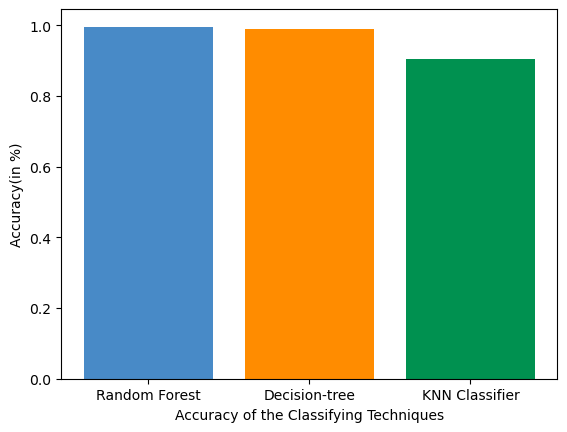

In [9]:
# create a dataset
Algorithms = ['Random Forest', 'Decision-tree','KNN Classifier']
Accuracy = [acc_rf, acc_dt, acc_gnb]

x_pos = np.arange(len(Accuracy))

# Create bars with different colors
plt.bar(x_pos, Accuracy, color=['#488AC7','#ff8c00','#009150'])

# Create names on the x-axis
plt.xticks(x_pos, Algorithms)
plt.ylabel('Accuracy(in %)')
plt.xlabel('Accuracy of the Classifying Techniques')

# Show graph
plt.show()

### Histograms to figure out relationship

Each histogram helps you understand the spread and concentration of data points for each feature, which can provide insights into the characteristics of your dataset and how the features relate to each other

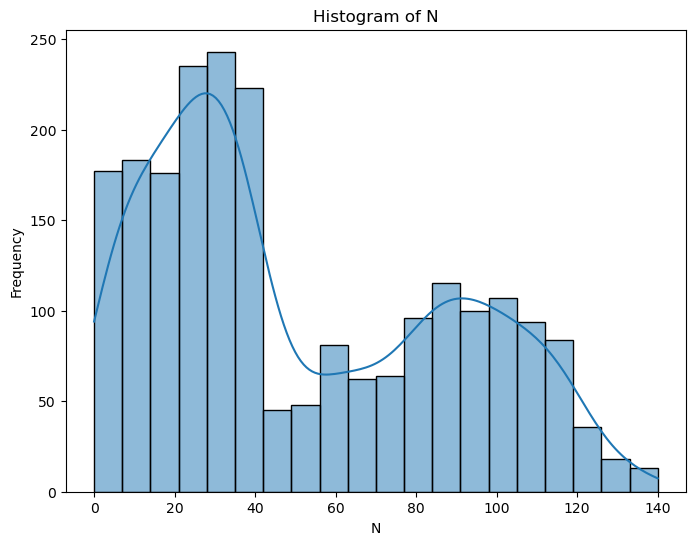

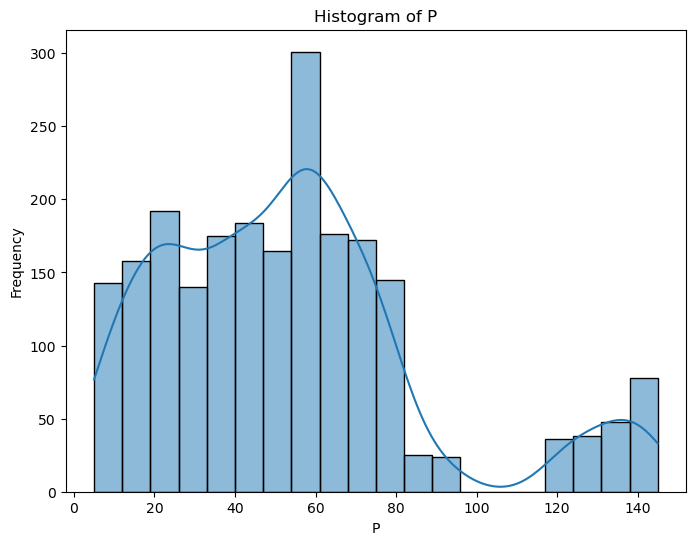

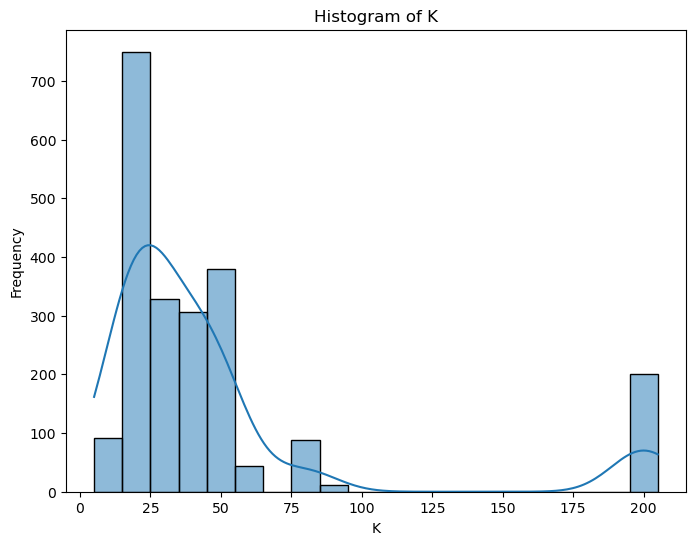

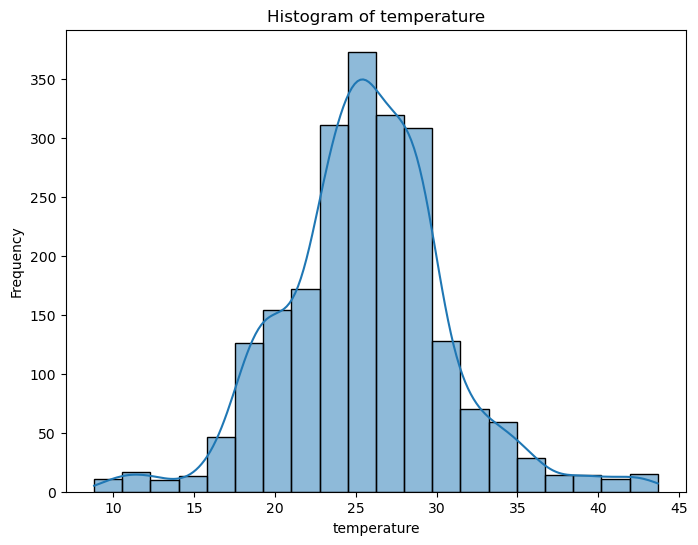

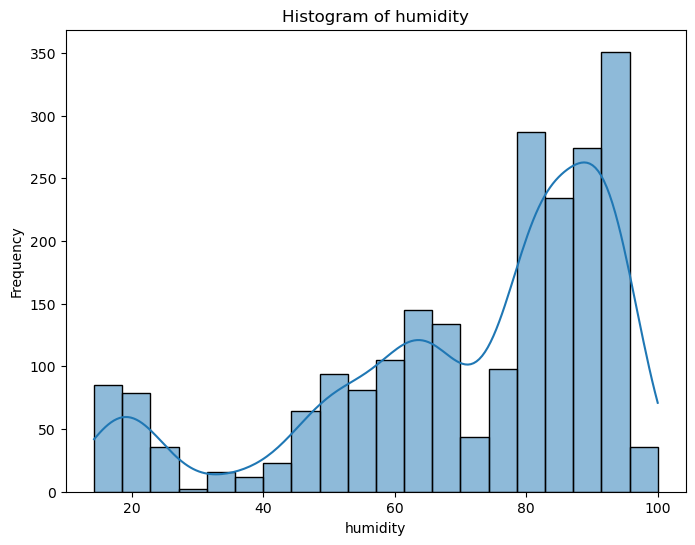

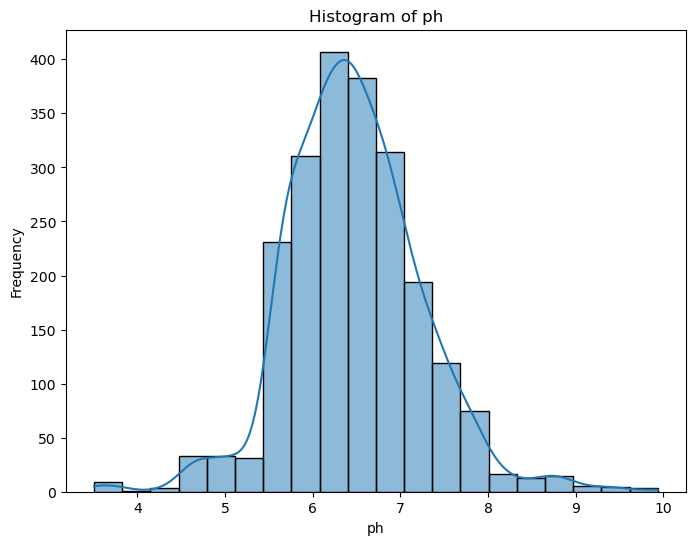

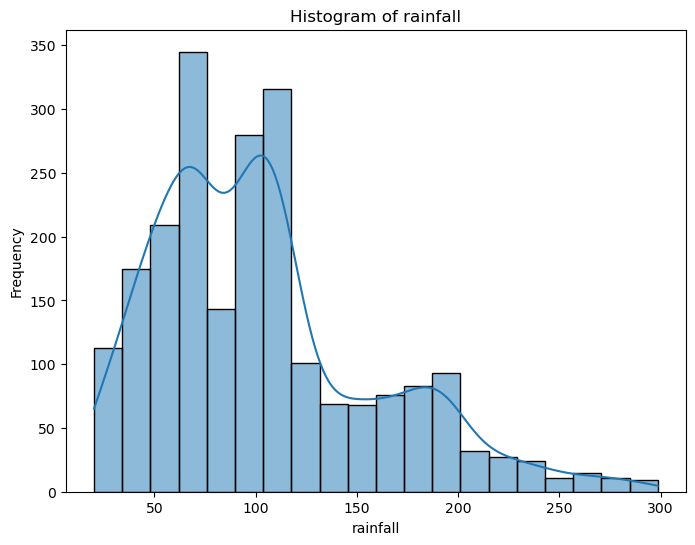

In [127]:
# Plot histograms for each feature
for feature in X_recommendation.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X_recommendation[feature], bins=20, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [140]:
# Take user input for features
print("\nEnter the following features to recommend a crop:")
N = float(input("Nitrogen content (N: mg/kg): "))
P = float(input("Phosphorus content (P: mg/kg): "))
K = float(input("Potassium content (K: mg/kg): "))
temperature = float(input("Temperature (in Celsius): "))
humidity = float(input("Humidity (in percentage): "))
ph = float(input("pH value: "))
rainfall = float(input("Rainfall (in mm): "))

# Predict the crop using the selected model
user_input = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
predicted_crop = selected_model.predict(user_input)
predicted_crop_name = list(crop_to_int.keys())[int(predicted_crop[0]) - 1]
predicted_crop_name=predicted_crop_name.capitalize()
print("\nRecommended crop based on provided features:", predicted_crop_name)




Enter the following features to recommend a crop:
Nitrogen content (N: mg/kg): 85
Phosphorus content (P: mg/kg): 58
Potassium content (K: mg/kg): 40
Temperature (in Celsius): 22
Humidity (in percentage): 83
pH value: 6.5
Rainfall (in mm): 210

Recommended crop based on provided features: Rice


## Now working with prediction


In [141]:
# Dropping missing values
crop_data = crop_data.dropna()
crop_data

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production,Yield
0,Maharashtra,AHMEDNAGAR,1997,Autumn,Maize,1.0,1113.0,1113.000000
1,Maharashtra,AHMEDNAGAR,1997,Kharif,Arhar/Tur,17600.0,6300.0,0.357955
2,Maharashtra,AHMEDNAGAR,1997,Kharif,Bajra,274100.0,152800.0,0.557461
3,Maharashtra,AHMEDNAGAR,1997,Kharif,Gram,40800.0,18600.0,0.455882
4,Maharashtra,AHMEDNAGAR,1997,Kharif,Jowar,900.0,1100.0,1.222222
...,...,...,...,...,...,...,...,...
12623,Maharashtra,YAVATMAL,2014,Rabi,Jowar,4000.0,3300.0,0.825000
12624,Maharashtra,YAVATMAL,2014,Rabi,Maize,1300.0,200.0,0.153846
12625,Maharashtra,YAVATMAL,2014,Rabi,Wheat,29100.0,26800.0,0.920962
12626,Maharashtra,YAVATMAL,2014,Summer,Groundnut,9400.0,11500.0,1.223404


In [142]:
# Adding a new column Yield which indicates Production per unit Area.

crop_data['Yield'] = (crop_data['Production'] / crop_data['Area'])
crop_data.head(10)


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production,Yield
0,Maharashtra,AHMEDNAGAR,1997,Autumn,Maize,1.0,1113.0,1113.000000
1,Maharashtra,AHMEDNAGAR,1997,Kharif,Arhar/Tur,17600.0,6300.0,0.357955
2,Maharashtra,AHMEDNAGAR,1997,Kharif,Bajra,274100.0,152800.0,0.557461
3,Maharashtra,AHMEDNAGAR,1997,Kharif,Gram,40800.0,18600.0,0.455882
4,Maharashtra,AHMEDNAGAR,1997,Kharif,Jowar,900.0,1100.0,1.222222
5,Maharashtra,AHMEDNAGAR,1997,Kharif,Maize,4400.0,4700.0,1.068182
6,Maharashtra,AHMEDNAGAR,1997,Kharif,Moong(Green Gram),10200.0,900.0,0.088235
7,Maharashtra,AHMEDNAGAR,1997,Kharif,Pulses total,451.0,130.0,0.288248
8,Maharashtra,AHMEDNAGAR,1997,Kharif,Ragi,2600.0,2100.0,0.807692
9,Maharashtra,AHMEDNAGAR,1997,Kharif,Rice,5900.0,7200.0,1.220339


In [143]:
crop_data_recommended=crop_data[crop_data["Crop"].str.contains(predicted_crop_name)]
print(crop_data_recommended.Season.unique())

['Kharif     ' 'Summer     ']


In [144]:
#filtering out more data to reduce the data set for prediction
print("\nEnter the following attributes to predict the recommended crop's production:")
district_name=str(input("District: "))
area=int(input("Area of field(hectares): "))
crop_data_recommended=crop_data_recommended[crop_data_recommended["District_Name"].str.contains(district_name.upper())]
print(crop_data_recommended)


Enter the following attributes to predict the recommended crop's production:
District: ahmednagar
Area of field(hectares): 3000
      State_Name District_Name  Crop_Year       Season  Crop    Area  \
9    Maharashtra    AHMEDNAGAR       1997  Kharif       Rice  5900.0   
31   Maharashtra    AHMEDNAGAR       1998  Kharif       Rice  5600.0   
62   Maharashtra    AHMEDNAGAR       1999  Kharif       Rice  5700.0   
94   Maharashtra    AHMEDNAGAR       2000  Kharif       Rice  5500.0   
124  Maharashtra    AHMEDNAGAR       2001  Kharif       Rice  7300.0   
156  Maharashtra    AHMEDNAGAR       2002  Kharif       Rice  7400.0   
187  Maharashtra    AHMEDNAGAR       2003  Kharif       Rice  7600.0   
223  Maharashtra    AHMEDNAGAR       2004  Kharif       Rice  8000.0   
252  Maharashtra    AHMEDNAGAR       2005  Kharif       Rice   800.0   
276  Maharashtra    AHMEDNAGAR       2006  Kharif       Rice  8400.0   
302  Maharashtra    AHMEDNAGAR       2007  Kharif       Rice    86.0   
330  Ma

Coefficients: [[0.79162093]]
Intercept: [543.62025173]


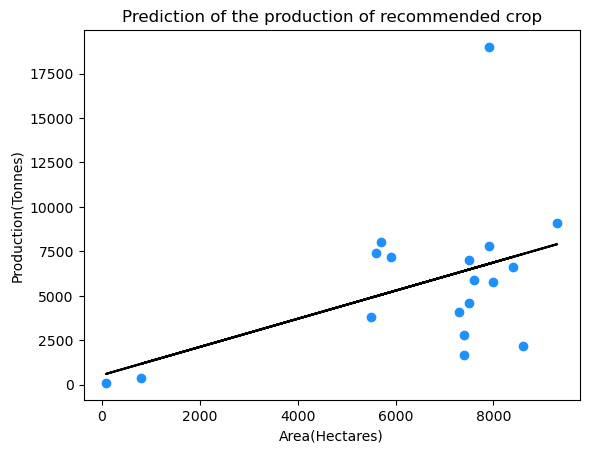


The Production of the recommended crop in tonnes in the district of  ahmednagar  is:  [[2918.48304299]]
Following are the seasons the crop should be grown: 
Kharif     


In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#defining the attribute, target and train test

X=np.array(crop_data_recommended["Area"]).reshape(-1,1)
Y=np.array(crop_data_recommended["Production"]).reshape(-1,1)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X, Y)
Y_pred=model.predict(X)
# Print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

plt.scatter(X, Y, color ='dodgerblue') #plot of test set
plt.plot(X, Y_pred, color ='k') #plot of the regression model
plt.xlabel('Area(Hectares)')
plt.ylabel('Production(Tonnes)')
plt.title('Prediction of the production of recommended crop')
plt.show()

Y_pred=model.predict([[area]])
print("\nThe Production of the recommended crop in tonnes in the district of ",district_name," is: ", Y_pred )
print("Following are the seasons the crop should be grown: ")
for i in crop_data_recommended.Season.unique():
    print(i)

## *Conclusion:*
The comparative study of three different supervised machine learning models (KNN, Decision Tree, and Random Forest) is done to predict the best-suited crop for the particular land that can help farmers to grow crops more efficiently.
In the future, new data from the fields can be collected to get a clear image of the soil and incorporate other machine learning algorithms and deep learning algorithms such as ANN or CNN to classify more varieties of crops. 

## *Refernces:*
Crop Selection and Yield Prediction using Machine Learning Approach – Current Agriculture Research Journal (agriculturejournal.org)

Crop-prediction-using-Machine-Learning/README.md at master · Priyabrata017/Crop-prediction-using-Machine-Learning · GitHub


